<div style='text-align: right; font-size: 12pt'>Brian Markley - Mar 8th, 2020</div>

# Predicting Winning Solitaire Decks
Analysis with Tensorflow and AdaBoostRegressor

---

After losing several hands of Solitaire in a row I've often wondered how sensitive the initial shuffle is to small changes. If I were to move a single card from the top to the middle, might I change a deck from a losing deck to a winning one? Or, is the winning nature in a shuffle more broad? Are there general qualities of a shuffled deck that will lead to a win regardless of a tiny change or two, like how well dispersed are the colors, or whether the card values alternate even to odd, or are bunched up in high and low value bunches.

If I could find generalization in winning decks and predict when new decks would win, the answer would be <span style='color:lightseagreen'><b>"A. General Qualities Win"</b></span>, but if I found no statistical similarities in winning decks, the answer would be <span style='color:lightseagreen'><b>"B. Specific Order Wins"</b></span>.

## Data & Process: 
I created a Solitaire [program][1] in python to play Solitaire and produce 10K decks of training data with a <b>card ID</b> (1-52) for each of the 52 locations in a shuffled deck (e.g. column x0 = top card, x51 = bottom card), a <b>won</b> flag (true|false), and the <b>num_moves</b> (1-156) played until the deck was either won or lost.

I targeted the <b>won</b> column with a simple Deep Model and the <b>num_moves</b> column with a regressor, and found NO generalizable features that helped predict either target, leading me to conclude that <span style='color:lightseagreen'><b>"B. Specific Order Wins."</b></span>
I would love to hear suggestions, and I have some specific questions at the end of the notebook. Thanks for taking a look!

[1]: https://github.com/countingpigeons/winningdeck/

---

# Contents

1. [Import](#1.-Import)
    - 1.1 [libraries](#1.1-Libraries)
    - 1.2 [data](#1.2-Data)
    - 1.3 [clean and transform](#1.3-Clean,-Transform)
    - 1.4 [summarize](#1.4-High-Level-Summary)

***

2. [Define Utility Functions](#2.-Define-Utility-Functions)
    - 2.1 [prep input arrays with dummies](#2.1-Prep-input-arrays)
    - 2.2 [deep model](#2.2-Deep-model)
    - 2.3 [regression](#2.3-Regression)
    - 2.4 [chart statistics](#2.4-Chart-statistics)

***
    
3. [Model: Raw Card Indexes (naiive)](#3.-Model:-Raw-Card-Indexes)
    - 3.1 [add feature: filter to deck positions where avg card diverges in winning decks](#3.1-Add-feature:-deck-positions-where-avg-card-diverges-in-winning-decks)
    - 3.2 [add feature: filter to deck positions which are initially exposed in game play](#3.2-Add-feature:-deck-positions-which-are-initially-exposed-in-game-play)
    - 3.3 [visualize index differences between specific positions in the deck](#3.3-Visualize-index-differences-between-specific-positions-in-the-deck)
    - 3.4 [create input arrays](#3.4-Create-input-arrays)
    - 3.5 [run models](#3.5-Run-models)


4. [Model: Summarize Important Initial Deck Positions](#4.-Model:-Summarize-Important-Deck-Positions)
    - 4.1 [create features (#exposed aces, #pile top kings, #pile top blacks, and #pile top evens)](#4.1-Create-features)
    - 4.2 [visualize](#4.2-Visualize)
    - 4.3 [normalize](#4.3-Normalize)
    - 4.4 [create input arrays](#4.4-Create-input-arrays)
    - 4.5 [run models](#4.5-Run-models)


5. [Model: Card Values and Suits](#5.-Model:-Card-Values-and-Suits)
    - 5.1 [dictionaries for val and suit](#5.1-Dictionaries-for-val-and-suit)
    - 5.2 [create new columns](#5.2-Create-new-columns)
    - 5.3 [add feature: deck positions where avg card diverges in winning decks](#5.3-Add-feature:-deck-positions-where-avg-card-diverges-in-winning-decks)
    - 5.4 [create input arrays](#5.4-Create-input-arrays)
    - 5.5 [run models](#5.5-Run-models)


6. [Model: Value offsets between deck positions](#6.-Model:-Value-offsets-between-deck-positions)
    - 6.1 [visualize card values between pairs of positions.](#6.1-Visualize-card-values-between-pairs-of-positions.)
    - 6.2 [create value offset features](#6.2-Create-value-offset-features)
    - 6.3 [create filter to identify new features](#6.3-Create-filter-to-identify-new-features)
    - 6.4 [create input arrays](#6.4-Create-input-arrays)
    - 6.5 [run models](#6.5-Run-models)


7. [Model: Deck Statistics](#7.-Model:-Deck-Statistics)
    - 7.1 [add feature: number of contiguous values](#7.1-Add-feature:-number-of-contiguous-values)
    - 7.2 [add feature: value balance between halves of the deck](#7.2-Add-feature:-value-balance-between-halves-of-the-deck)
    - 7.3 [add feature: color balance between alternating cards](#7.3-Add-feature:-color-balance-between-alternating-cards)
    - 7.4 [add feature: color balance between halves of the deck](#7.4-Add-feature:-color-balance-between-halves-of-the-deck)
    - 7.5 [add feature: color balance from top to bottom continuously](#7.5-Add-feature:-color-balance-from-top-to-bottom-continuously)
    - 7.6 [create filter for new features](#7.6-Create-filter-for-new-features)
    - 7.7 [summarize and visualize](#7.7-Summarize-and-visualize)
    - 7.8 [create input arrays](#7.8-Create-input-arrays)
    - 7.9 [run models](#7.9-Run-models)


8. [Model: Identify Quick Losers](#8.-Model:-Identify-Quick-Losers)
    - 8.1 [find minimum move threshold for a 'fun' deck](#8.1-Find-minimum-move-threshold-for-a-'fun'-deck)
    - 8.2 [create input arrays](#8.2-Create-input-arrays)
    - 8.3 [run models](#8.3-Run-models)


9. [Model: Gut Check](#9.-Model:-Gut-Check)
    - 9.1 [degrade num_moves with random noise](#9.1-Degrade-num_moves-feature-with-random-noise)
    - 9.2 [create input arrays (with noisy num_moves added)](#9.2-Create-input-arrays)
    - 9.3 [run models](#9.3-Run-models)

***
    
10. [Conclusions and Questions](#10.-Conclusions-and-Questions)

## 1. Import

#### 1.1 Libraries

In [1]:
# config
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind

# sklearn tools
from sklearn import preprocessing

# sklearn models
from sklearn.ensemble import AdaBoostRegressor

# deep model
np.random.seed(0)
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

#### 1.2 Data

In [2]:
data = pd.read_csv('../winningdeck/winning_deck_results')
pd.DataFrame(data.dtypes).transpose()
data.head(3)

deck num_moves     won     x0     x1     x2     x3     x4     x5     x6  \
0  int64     int64  object  int64  int64  int64  int64  int64  int64  int64   

   ...      x42    x43    x44    x45    x46    x47    x48    x49    x50    x51  
0  ...    int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  

[1 rows x 55 columns]

deck  num_moves     won  x0  x1  x2  x3  x4  x5  x6 ...   x42  x43  x44  \
0     0        138    True  29  13  46  42  39   8   6 ...    31   20   26   
1     1         21   False  50  10  38  23   3  39  20 ...    42   31   29   
2     2         43   False  16  30  10  22   5   7  52 ...    14   39   17   

   x45  x46  x47  x48  x49  x50  x51  
0   32   33   17    3   27   49   25  
1   32    8   17    5   49   37    9  
2   20   43   11   24   51    6    4  

[3 rows x 55 columns]

#### 1.3 Clean, Transform

##### transform won/lost as integer

In [3]:
data.loc[:,'won'] = data.won.str.contains('True').replace({True:1,False:0})

##### transform categorical columns

In [4]:
# all "x" columns
card_column_names = list(filter(lambda column: column[0:1]=='x', list(data.columns)))
card_columns = data.columns.isin(card_column_names)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for column in card_column_names:
        data.loc[:,column] = pd.Categorical(data[column])

#### 1.4 High Level Summary
    Approximately 19% are winning decks, and the "num_moves" field clearly distinguishes winners from losers.

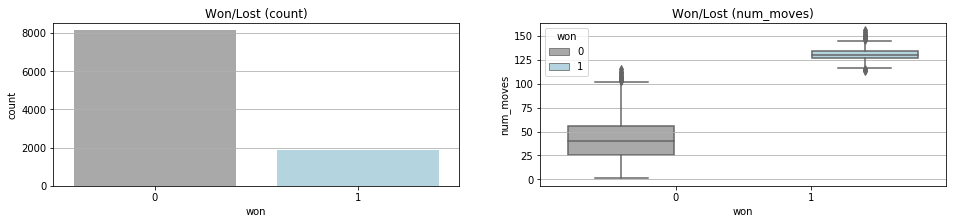

In [5]:
fig, axes = plt.subplots(1,2,figsize=[16,3])

_= sns.countplot(x='won', data=data, ax=axes[0], palette={0:'darkgrey',1:'lightblue'})
_= sns.boxplot(x='won', y='num_moves', hue='won', data=data, ax=axes[1], palette={0:'darkgrey',1:'lightblue'}, width=1.6)
_=axes[0].set_title('Won/Lost (count)')
_=axes[1].set_title('Won/Lost (num_moves)')
_=axes[1].set_xlim(-1,2)
for ax in axes:
    ax.yaxis.grid(True)

In [6]:
details = data.groupby('won')['num_moves'].agg([len,min, max, np.mean]).\
    rename(columns={'len':'Num','min':'MinMoves','max':'MaxMoves', 'mean':'MeanMoves'})
details.MeanMoves = details.MeanMoves.transform(int)
details['Ratio'] = details.Num.transform(lambda x:x/len(data))
details

Num  MinMoves  MaxMoves  MeanMoves   Ratio
won                                             
0    8129         1       115         41  0.8129
1    1871       113       156        130  0.1871

## 2. Define Utility Functions

#### 2.1 Prep input arrays

In [7]:
train_pct = 0.75
data_rows = data.shape[0]
train_rows = int(np.ceil(data_rows * train_pct))
training_index = data.sample(train_rows, random_state=0).index

def split_train_test(df):
    train = df.loc[training_index]
    test = df.loc[~df.index.isin(training_index)]
    return train, test

In [8]:
def array_with_dummies(df, columns):
    array = np.array(pd.get_dummies(df.loc[:, columns], drop_first=True, sparse=True))
    return array

#### 2.2 Deep model

In [9]:
def make_deep_model(training_array):
    num_input_features = training_array[0].size
    num_hidden_neurons = min(num_input_features//2, 13)

    deep_model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(num_input_features, activation='relu'),
      tf.keras.layers.Dense(num_hidden_neurons, activation='sigmoid'),
      tf.keras.layers.Dense(3),
      tf.keras.layers.Dropout(rate=0.2, seed=0),
      tf.keras.layers.Dense(2, activation='softmax')
    ])

    deep_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return deep_model

In [10]:
def chart_predictions(model, test_array, fitted_model):

    probas = model.predict_proba(test_array)[:,1]
    num_moves = y_test_regress
    won = y_test
    if str(model.name)[:10] == 'sequential':
        model_name = 'Deep Model'
    else: model_name = 'Sklearn Model'

    fig, axes = plt.subplots(1, 2, figsize=[16, 4])    
    _=fig.suptitle('{} (inputs: {})'.format(model_name, str(test_array.shape[1])), fontsize=12)
    _=axes[0].plot(fitted_model.history['acc'], label='train', color='royalblue', linewidth=2, marker='o')
    _=axes[0].plot(fitted_model.history['val_acc'], label='validate', color='gray', linewidth=2, marker='o')
    _=axes[0].set_xlabel('Training Epoch')
    _=axes[0].set_ylabel('Accuracy (ratio)')
    _=axes[0].set_title('Training')
    _=axes[0].legend()
    _=axes[0].set_xticks([0,1,2,3,4])
    _=axes[0].set_xticklabels(['1','2','3','4','5'])
    _=axes[0].set_ylim([.6,1.05])

    _=axes[1].scatter(probas, num_moves, c=won, s=1, cmap='coolwarm_r', label='blue:won, red:lost')
    _=axes[1].set_xlabel('Probability Won (predicted)')
    _=axes[1].set_ylabel('Num Moves (actual)')
    _=axes[1].set_title('Test Predictions')
    _=axes[1].legend()

In [11]:
def deep_model_and_chart(train_x, train_y, test_x, test_y, baseline=0):
    deep_model = make_deep_model(train_x)
    fitted_model=deep_model.fit(train_x, train_y, epochs=5, verbose=0, validation_split=.10)
    
    model_accuracy = deep_model.evaluate(test_x, test_y, verbose=0)[1]
    baseline = max(baseline, len(test.loc[test.won==0]) / len(test))  #ratio of LOST in test set

    print('Accuracy: {:.4f}'.format(model_accuracy))
    print('     vs. baseline: {:.4f}'.format(model_accuracy - baseline))
    chart_predictions(deep_model, test_x, fitted_model)

#### 2.3 Regression

In [12]:
adaboostregressor = AdaBoostRegressor(random_state = 0,loss='linear')

def chart_regression(model, test_array):
    predicted_moves = model.predict(test_array)
    num_moves = y_test_regress
    won = y_test
    model_name = adaboostregressor.__str__()
    model_name = model_name[:model_name.index('(')]
    _=plt.scatter(predicted_moves, num_moves, c=won, s=1, cmap='coolwarm_r')
    _=plt.xlabel('Num Moves (predicted)')
    _=plt.ylabel('Num Moves (actual)')
    _=plt.xlim(0, 160)
    _=plt.ylim(0, 160)
    _=plt.title('{} (inputs: {})'.format(model_name, str(test_array.shape[1])))

def regress_and_chart(train_x, train_y, test_x, test_y):
    _=adaboostregressor.fit(train_x, train_y)
    R2 = adaboostregressor.score(test_x, test_y)
    
    print('R^2: {}'.format(round(R2, 2)))
    chart_regression(adaboostregressor, test_x)    

#### 2.4 Chart statistics

In [13]:
def chart_column_stats(column_name_str, title_str, xlabel_str):
    won_mean = data.loc[data.won==1, column_name_str].mean()
    won_std = data.loc[data.won==1, column_name_str].std()
    lost_mean = data.loc[data.won==0, column_name_str].mean()
    lost_std = data.loc[data.won==0, column_name_str].std()
    ttest = ttest_ind(data.loc[data.won==1, column_name_str], data.loc[data.won==0, column_name_str])
    ftest = (won_std ** 2) / (lost_std ** 2)
    print('Mean Difference | p: {:.2f} | F: {:.3f}'.format(ttest[1], ftest))

    won_color, lost_color = 'blue','darkgrey'
    diffs = data.loc[:, column_name_str]
    num_moves = data.loc[:, 'num_moves']
    won = data.loc[:, 'won']
    won = data.loc[:, 'won'].transform(lambda x: won_color if x==1 else lost_color)
    plot=plt.scatter(diffs, num_moves, c=won, s=1, alpha=.5)
    plot=plt.xlabel(xlabel_str)
    plot=plt.ylabel('Num Moves (actual)')

    plot=plt.axvline(x=lost_mean, color=lost_color, linewidth=1)
    plot=plt.axvline(x=lost_mean-lost_std, color=lost_color, linewidth=1, linestyle='--')
    plot=plt.axvline(x=lost_mean+lost_std, color=lost_color, linewidth=1, linestyle='--')

    plot=plt.axvline(x=won_mean, color=won_color, linewidth=1)
    plot=plt.axvline(x=won_mean-won_std, color=won_color, linewidth=1, linestyle='--')
    plot=plt.axvline(x=won_mean+won_std, color=won_color, linewidth=1, linestyle='--')

    plot=plt.title(title_str,fontsize=15)

## 3. Model: Raw Card Indexes

#### 3.1 Add feature: deck positions where avg card diverges in winning decks

    Average card index per deck position in winning and losing decks.

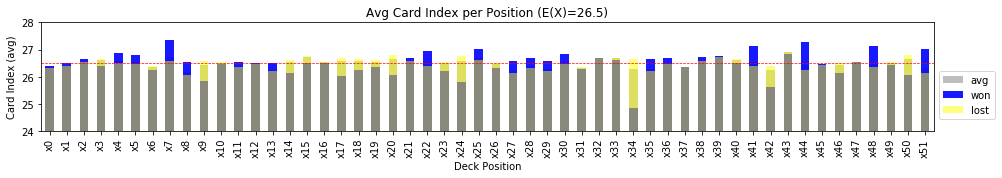

In [14]:
_=data.loc[:,card_columns].mean().plot(kind='bar',color='grey',figsize=[16,2], alpha=0.5, ylim=[24,28], label='avg')
_=data.loc[data.won==1,card_columns].mean().plot(kind='bar',color='blue', alpha=0.9, label='won')
_=data.loc[data.won==0,card_columns].mean().plot(kind='bar',color='yellow', alpha=0.5, label='lost')
_=plt.legend(bbox_to_anchor=(1, .6))
_=plt.axhline(y=26.5, color='r', linestyle='--', linewidth=0.7)
_=plt.xlabel('Deck Position')
_=plt.ylabel('Card Index (avg)')
_=plt.title('Avg Card Index per Position (E(X)=26.5)')

    Create feature of deck positions where winning decks diverge from expected 26.5 (blue peaks above/below red line)

In [15]:
divergent_column_names = ['x7','x22','x25','x34','x41','x44','x48','x51']
divergent_columns = data.columns.isin(divergent_column_names)

#### 3.2 Add feature: deck positions which are initially exposed in game play

    Create feature of deck positions guaranteed to be exposed in every game (pile tops and initial every-third).

In [16]:
initial_exposed_column_names = ['x0','x7','x13','x18','x22','x25','x27']
initial_playpile_column_names = ['x30','x33','x36','x39','x42','x45','x48','x51']

filtered_column_names = initial_exposed_column_names.copy()
filtered_column_names.extend(initial_playpile_column_names)
filtered_columns = data.columns.isin(filtered_column_names)

#### 3.3 Visualize index differences between specific positions in the deck

    Do certain cards often appear at a given offset from each other in winning decks? (e.g. if the top card ('x0') is a red 3-of-hearts (index 28), is it common in winning decks for the 20th card ('x19') to be a black 4 (index 3 or 16)?) 

    I may expect to see diagonal lines where value/color combinations relate to other value/color combinations at specific depths from that card location.

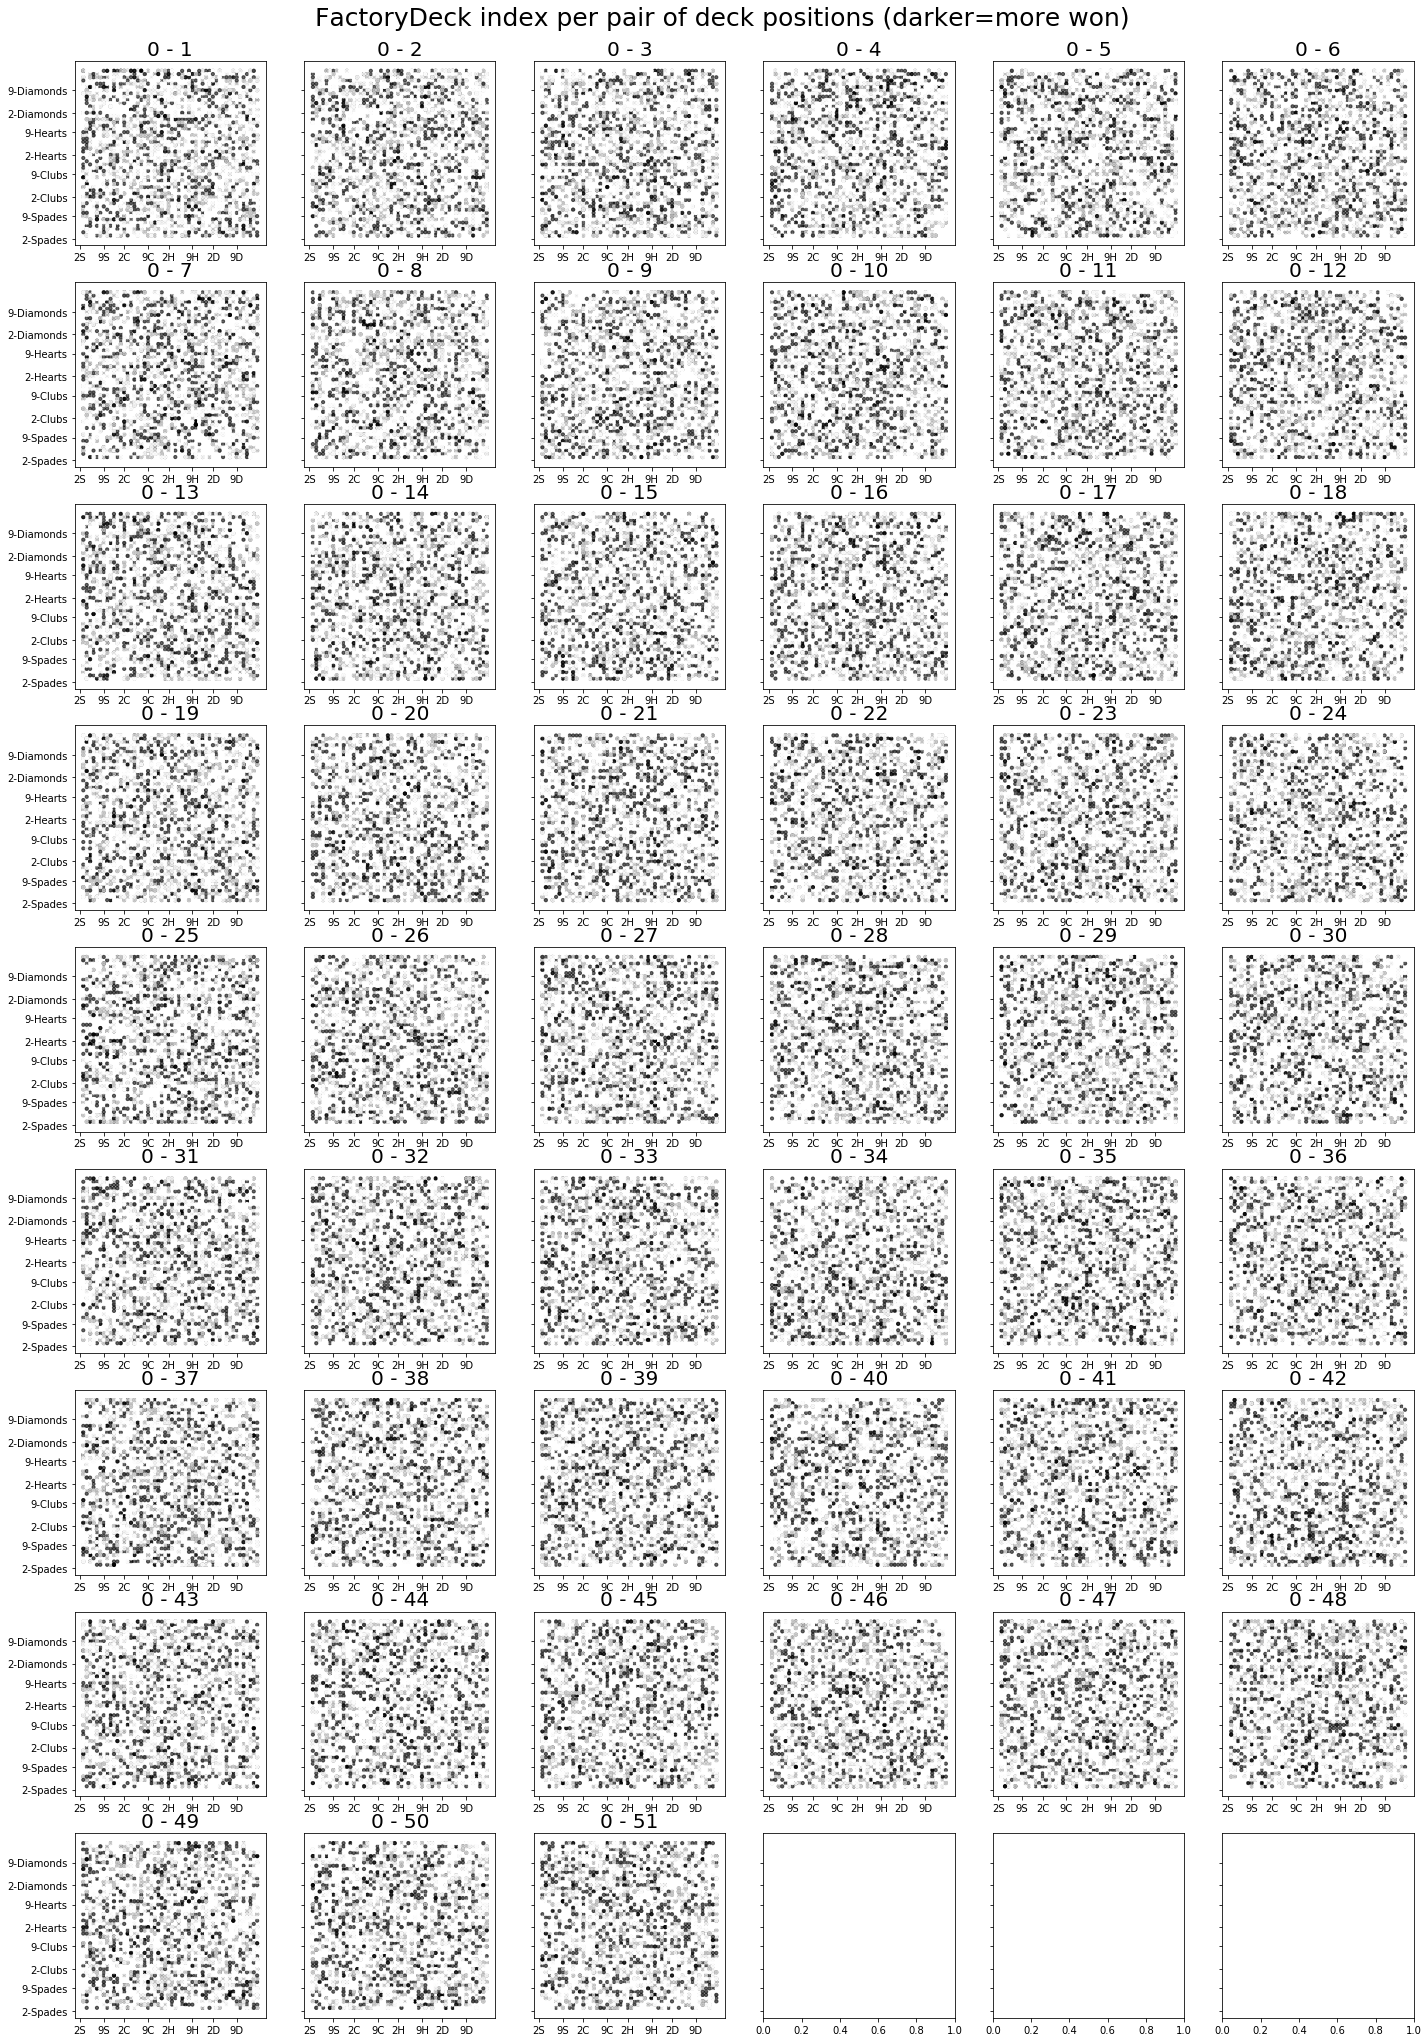

In [17]:
numrows=9
ax_row = 0
ax_col = -1
tickrange=[0,7,13,20,26,33,39,46]
xticklabels=['2S','9S','2C','9C','2H','9H','2D','9D']
yticklabels=['2-Spades','9-Spades','2-Clubs','9-Clubs','2-Hearts','9-Hearts','2-Diamonds','9-Diamonds']

fig, axes = plt.subplots(nrows=numrows, ncols=6, figsize=[24,4*numrows],sharey=True)
_=fig.suptitle(t='FactoryDeck index per pair of deck positions (darker=more won)', fontsize=25, y=(1-(.011*numrows)))

x = 'x0'
for column in card_column_names[:]:
    if int(column[1:]) == 0:
        continue
    y = column
    
    if ax_col == 5:
        ax_row+=1
        ax_col=0
    else: 
        ax_col+=1        
    ax = axes[ax_row][ax_col]

    _=ax.scatter(x=data[x], y=data[y], c=data['won'], cmap='binary', s=10, alpha=.6)
    _=ax.set_xticks(tickrange)
    _=ax.set_xticklabels(xticklabels)
    _=ax.set_yticks(tickrange)
    _=ax.set_yticklabels(yticklabels)
    _=ax.set_title(label='{} - {}'.format(x[1:], y[1:]), fontdict={'fontsize':20})

    Initially plotting only the top card against the other 51 deck positions doesn't reveal a clear relationship. Not expanding to all pair-wise comparisons since spot checking those also doesn't reveal any patterns.

#### 3.4 Create input arrays

##### split train & test

In [18]:
train, test = split_train_test(data)
train.shape, test.shape

((7500, 55), (2500, 55))

    Train/Test Details

In [19]:
fig, axes = plt.subplots(1,2,figsize=[16,3],constrained_layout=True)

_= sns.countplot(x='won', data=train, ax=axes[0], palette={0:'darkgrey',1:'lightblue'})
_= sns.countplot(x='won', data=test, ax=axes[1], palette={0:'darkgrey',1:'lightblue'})
_=axes[0].set_title('Train')
_=axes[1].set_title('Test')

train_win_ratio = train.won.mean()
test_win_ratio = test.won.mean()

print('TRAIN - Won: {}  Lost: {}'.format(train_win_ratio.round(4), (1-train_win_ratio).round(4)))
print('TEST - Won: {}  Lost: {}'.format(test_win_ratio.round(4), (1-test_win_ratio).round(4)))
print('Diff in win means: {}'.format(abs(train_win_ratio - test_win_ratio).round(4)))
print('    p value that Diff is random: {}'.format(ttest_ind(train.won, test.won)[1].round(4)))

TRAIN - Won: 0.1887  Lost: 0.8113
TEST - Won: 0.1824  Lost: 0.8176
Diff in win means: 0.0063
    p value that Diff is random: 0.4866


p value that num_moves Diff is random: 0.2808


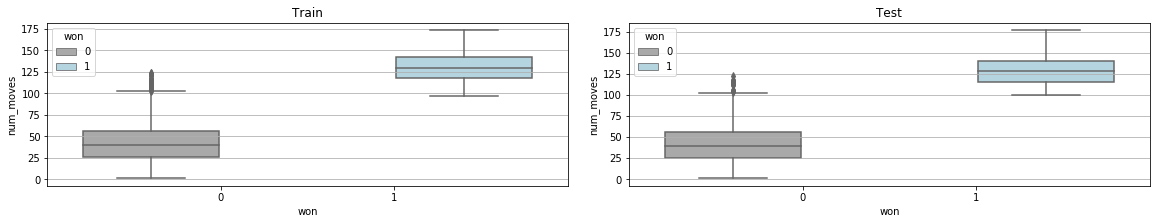

In [109]:
fig, axes = plt.subplots(1,2,figsize=[16,3],constrained_layout=True)

_= sns.boxplot(x='won', y='num_moves', hue='won', data=train, ax=axes[0], palette={0:'darkgrey',1:'lightblue'}, width=1.6)
_= sns.boxplot(x='won', y='num_moves', hue='won', data=test, ax=axes[1], palette={0:'darkgrey',1:'lightblue'}, width=1.6)

for ax in axes:
    _=ax.set_xlim(-1,2)
    _=ax.yaxis.grid(True)
_=axes[0].set_title('Train')
_=axes[1].set_title('Test')

print('p value that num_moves Diff is random: {:.4f}'.format(ttest_ind(train.num_moves, test.num_moves)[1]))

Baseline (ratio LOST in the test set) = .8176.

<b><span style="color:lightseagreen">Split looks good.</span></b> 

##### Make arrays

In [21]:
X_train = array_with_dummies(train, card_columns)
X_train_filtered = array_with_dummies(train, filtered_columns)
X_train_divergent = array_with_dummies(train, divergent_columns)

y_train = np.array(train.loc[:,(train.columns=='won')].iloc[:,0])

In [22]:
X_test = array_with_dummies(test, card_columns)
X_test_filtered = array_with_dummies(test, filtered_columns)
X_test_divergent = array_with_dummies(test, divergent_columns)

y_test = np.array(test.loc[:,(test.columns=='won')].iloc[:,0])

alternate y for regression on 'num_moves'

In [23]:
y_train_regress = np.array(train.loc[:,(train.columns=='num_moves')].iloc[:,0])
y_test_regress = np.array(test.loc[:,(test.columns=='num_moves')].iloc[:,0])

In [24]:
X_train.shape, X_test.shape
X_train_filtered.shape, X_test_filtered.shape
X_train_divergent.shape, X_test_divergent.shape

y_train.shape, y_test.shape
y_train_regress.shape, y_test_regress.shape

((7500, 2652), (2500, 2652))

((7500, 765), (2500, 765))

((7500, 408), (2500, 408))

((7500,), (2500,))

((7500,), (2500,))

#### 3.5 Run models

##### Tensorflow

Accuracy: 0.8104
     vs. baseline: -0.0072


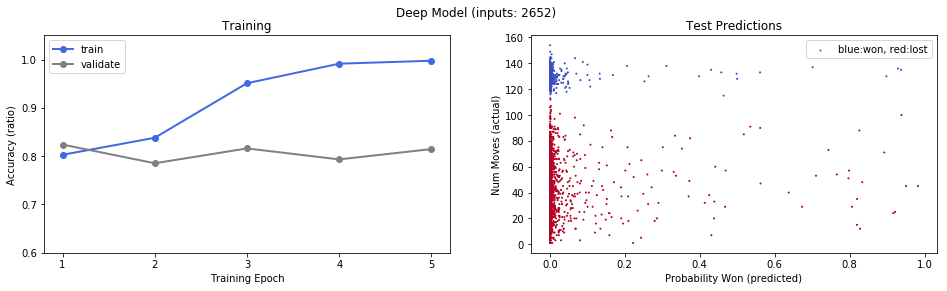

In [25]:
deep_model_and_chart(X_train, y_train, X_test, y_test)

Accuracy: 0.7880
     vs. baseline: -0.0296


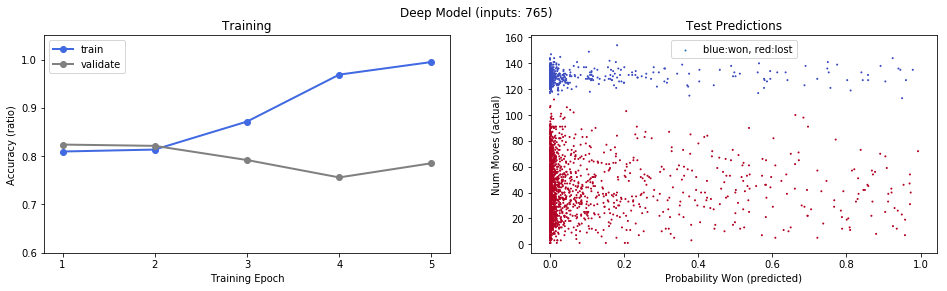

In [26]:
deep_model_and_chart(X_train_filtered,y_train,X_test_filtered,y_test)

Accuracy: 0.8056
     vs. baseline: -0.0120


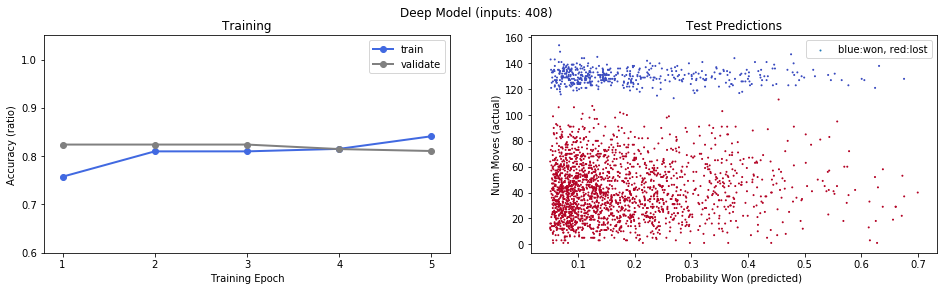

In [27]:
deep_model_and_chart(X_train_divergent,y_train,X_test_divergent,y_test)

    Center and distribution match between Won and Lost so no useful signal on these feature sets.

##### AdaBoostRegressor - 'num_moves'

In [28]:
regress_and_chart(X_train, y_train_regress, X_test, y_test_regress)

R^2: -0.06


In [29]:
regress_and_chart(X_train_filtered, y_train_regress, X_test_filtered, y_test_regress)

R^2: -0.05


In [30]:
regress_and_chart(X_train_divergent, y_train_regress, X_test_divergent, y_test_regress)

R^2: -0.04


    Poor regression. R^2 very near 0, so explains little to none of variation.

<b><span style="color:indian red; font-size:14pt">No signal.</span></b>

## 4. Model: Summarize Important Deck Positions

Summarize among cards on top of the initial 7 piles, and those exposed in the 1st cycle through play deck.

1. number of <b>aces</b> exposed (<i>perhaps high number is helpful, since all playable</i>)

2. number of <b>kings</b> in pile tops (<i>perhaps high number hurtful, since can't play on other cards</i>)

3. ratio of <b>red / black</b> cards in pile tops. (<i>Better if all one color, or balanced 50/50? If all same color, none can play on each other initially</i>)

4. ratio of <b>even / odd</b> cards in pile tops. (<i>Better if all same, or if balanced? If all same, none can play on each other initially</i>)

#### 4.1 Create features

In [31]:
# card indexes corresponding to various categories.
aces = [13, 26, 39, 52]
kings = [12, 25, 38, 51]
black = list(range(1,27))
evens = [1,3,5,7,9,11,14,16,18,20,22,24,27,29,31,33,35,37,40,42,44,46,48,50]

In [32]:
data.loc[:, 'i_exposed_aces'] = data.loc[:, filtered_columns].\
            transform(lambda x: x.isin(aces)).replace({True:1, False:0}).sum(axis=1)
data.loc[:, 'i_pile_kings'] =   data.loc[:, initial_exposed_column_names].\
            transform(lambda x: x.isin(kings)).replace({True:1, False:0}).sum(axis=1)
data.loc[:, 'i_pile_blacks'] =  data.loc[:, initial_exposed_column_names].\
            transform(lambda x: x.isin(black)).replace({True:1, False:0}).sum(axis=1)
data.loc[:, 'i_pile_evens'] =   data.loc[:, initial_exposed_column_names].\
            transform(lambda x: x.isin(evens)).replace({True:1, False:0}).sum(axis=1)

In [33]:
important_card_column_names = list(filter(lambda x:x[0:2]=='i_', list(data.columns)))
important_card_column_names
important_card_columns = data.columns.isin(important_card_column_names)

['i_exposed_aces', 'i_pile_kings', 'i_pile_blacks', 'i_pile_evens']

#### 4.2 Visualize

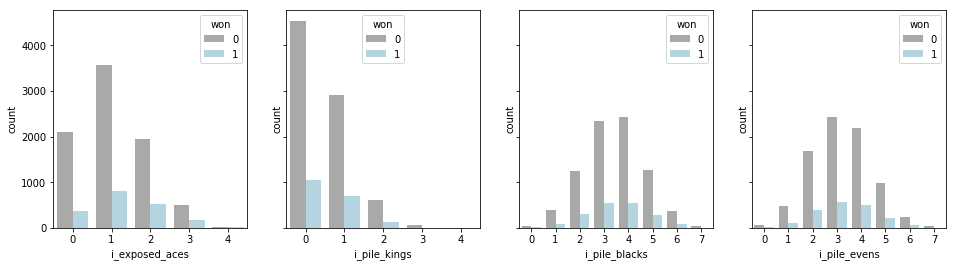

In [34]:
num_plots = len(important_card_column_names)

fig, axes = plt.subplots(1,num_plots,sharey=True,figsize=[16,4])
ax = 0
for column in important_card_column_names:
    sns_plot = sns.countplot(x=column, hue='won', palette = {0:'darkgrey',1:'lightblue'},data=data, ax=axes[ax])
    ax+=1

No obvious win/lose ratio differences based on these factors.

#### 4.3 Normalize

In [35]:
for column in important_card_column_names:
    mean = data[column].mean()
    std = data[column].std()
    data.loc[:, column] = data.loc[:,column].transform(lambda x: (x-mean)/std)

#### 4.4 Create input arrays

##### Split train/test

In [36]:
train, test = split_train_test(data)
train.shape, test.shape

((7500, 59), (2500, 59))

##### Make arrays

In [37]:
X_train_important_column_features = np.array(train.loc[:, important_card_columns])
X_test_important_column_features = np.array(test.loc[:, important_card_columns])

X_train_important_column_features.shape, X_test_important_column_features.shape

((7500, 4), (2500, 4))

Polynomial versions.

In [38]:
poly = preprocessing.PolynomialFeatures(degree=4, interaction_only=True)
X_train_poly_important_column_features = poly.fit_transform(X_train_important_column_features, y_train)
X_test_poly_important_column_features = poly.fit_transform(X_test_important_column_features, y_test)

X_train_poly_important_column_features.shape, X_test_poly_important_column_features.shape

((7500, 16), (2500, 16))

#### 4.5 Run models

Tensorflow

In [39]:
deep_model_and_chart(X_train_important_column_features, y_train, X_test_important_column_features, y_test)

Accuracy: 0.8176
     vs. baseline: 0.0000


Accuracy: 0.8176
     vs. baseline: 0.0000


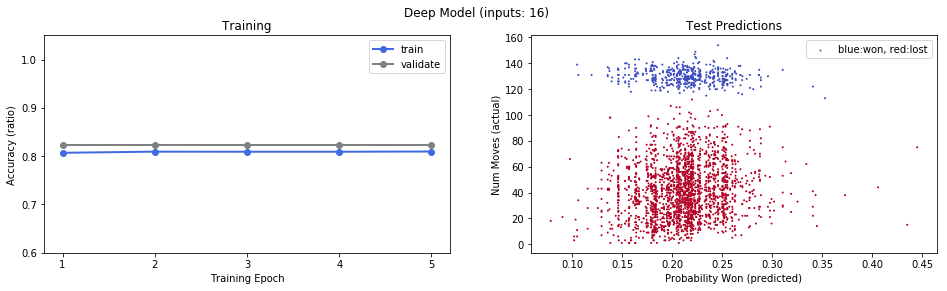

In [40]:
deep_model_and_chart(X_train_poly_important_column_features, y_train, X_test_poly_important_column_features, y_test)

AdaBoostRegressor on 'num_moves'

In [41]:
regress_and_chart(X_train_important_column_features, y_train_regress,\
                  X_test_important_column_features, y_test_regress)

R^2: -0.03


In [42]:
regress_and_chart(X_train_poly_important_column_features, y_train_regress,\
                  X_test_poly_important_column_features, y_test_regress)

R^2: -0.07


<b><span style="color:indian red; font-size:14pt">No signal.</span></b>
Still predicting LOSE for all decks.

## 5. Model: Card Values and Suits

<b>RE-CODE</b> the input data to reflect card <b>VALUES</b> and <b>SUITS</b> instead of indexes in a factory deck.
  
1. create 52 <b>card value</b> columns with values (1-13).
2. create 52 <b>card suit</b> columns with values (1-4). e.g. ("x0_val" [1-13], "x0_suit" [1-4], "X1_val" ...)

#### 5.1 Dictionaries for val and suit

In [43]:
# our factory deck order is Two through Ace repeated 4 times.
card_values = list(range(2,14))
card_values.append(1)
card_values = card_values * 4

# our factory deck order is Spades, Clubs, Hearts, Diamonds, 13 each.
card_suits = ([1]*13) + ([2]*13) + ([3]*13) + ([4]*13)


card_indexes = range(1,53)

# dictionaries
cardval_dict = dict(zip(card_indexes,card_values))
cardsuit_dict = dict(zip(card_indexes,card_suits))

#### 5.2 Create new columns

In [44]:
x_columns = list(filter(lambda x:x[0:1]=='x', list(data.columns)))
for col in x_columns:
    newcol = 'val_'+ col[1:]
    data.loc[:, newcol] = pd.Categorical(data.loc[:, col].transform(lambda x:cardval_dict[x]))

value_column_names = list(filter(lambda x:x[0:4]=='val_', list(data.columns)))
print('sample of new value_columns: {}'.format(value_column_names[0:5]))
value_columns = data.columns.isin(value_column_names)

sample of new value_columns: ['val_0', 'val_1', 'val_2', 'val_3', 'val_4']


In [45]:
for col in x_columns:
    newcol = 'suit_'+ col[1:]
    data.loc[:, newcol] = pd.Categorical(data.loc[:, col].transform(lambda x:cardsuit_dict[x]))

suit_column_names = list(filter(lambda x:x[0:5]=='suit_', list(data.columns)))
print('sample of new suit_columns: {}'.format(suit_column_names[0:5]))
suit_columns = data.columns.isin(suit_column_names)

sample of new suit_columns: ['suit_0', 'suit_1', 'suit_2', 'suit_3', 'suit_4']


In [46]:
value_and_suit_column_names = []
value_and_suit_column_names.extend(value_column_names)
value_and_suit_column_names.extend(suit_column_names)

value_and_suit_columns = data.columns.isin(value_and_suit_column_names)

#### 5.3 Add feature: deck positions where avg card diverges in winning decks

In [47]:
_=data.loc[:,value_columns].mean().plot(kind='bar',color='grey',figsize=[16,2], alpha=0.5, ylim=[5,8], label='avg')
_=data.loc[data.won==1,value_columns].mean().plot(kind='bar',color='blue', alpha=0.9, label='won')
_=data.loc[data.won==0,value_columns].mean().plot(kind='bar',color='yellow', alpha=0.5, label='lost')
_=plt.axhline(y=7, color='r', linestyle='--', linewidth=0.7)
_=plt.legend(bbox_to_anchor=(1, .6))
_=plt.xlabel('Deck Position')
_=plt.ylabel('Card Value (avg)')
_=plt.title('Avg Card Value per Position (E(X)=7)')

##### make new filters

In [48]:
divergent_value_column_names = ['val_3','val_4','val_6','val_24','val_25','val_27','val_28']
divergent_suit_column_names = ['suit_3','suit_4','suit_6','suit_24','suit_25','suit_27','suit_28']
divergent_value_and_suit_column_names = divergent_value_column_names.copy()
divergent_value_and_suit_column_names.extend(divergent_suit_column_names)

divergent_value_and_suit_columns = data.columns.isin(divergent_value_and_suit_column_names)

#### 5.4 Create input arrays

In [49]:
train, test = split_train_test(data)

In [50]:
X_train_recode = array_with_dummies(train, value_and_suit_columns)
X_test_recode = array_with_dummies(test, value_and_suit_columns)
X_train_recode.shape
X_test_recode.shape

(7500, 780)

(2500, 780)

In [51]:
X_train_recode_divergent = array_with_dummies(train, divergent_value_and_suit_columns)
X_test_recode_divergent = array_with_dummies(test, divergent_value_and_suit_columns)
X_train_recode_divergent.shape
X_test_recode_divergent.shape

(7500, 105)

(2500, 105)

#### 5.5 Run models

Tensorflow

Accuracy: 0.7952
     vs. baseline: -0.0224


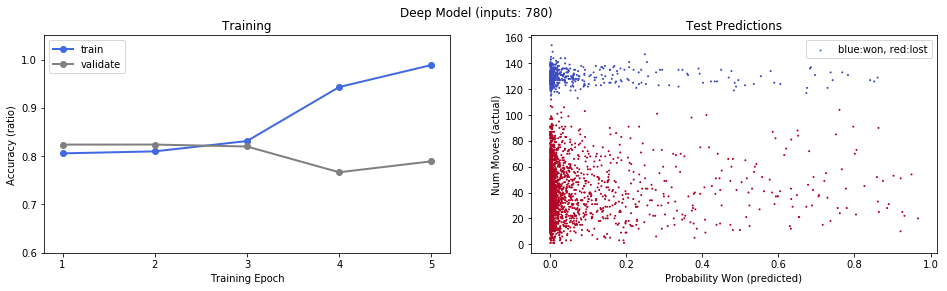

In [52]:
deep_model_and_chart(X_train_recode, y_train, X_test_recode, y_test)

Accuracy: 0.8180
     vs. baseline: 0.0004


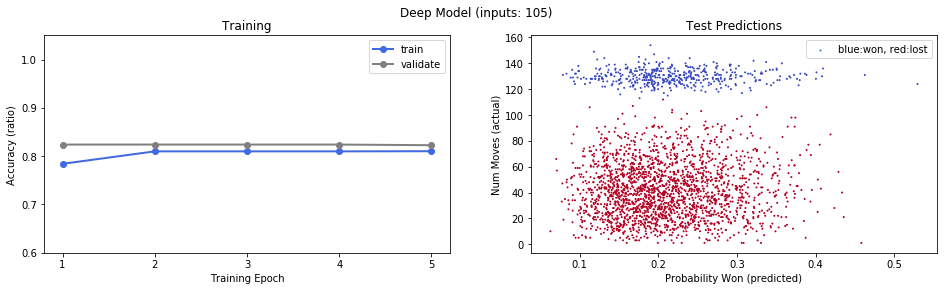

In [53]:
deep_model_and_chart(X_train_recode_divergent, y_train, X_test_recode_divergent, y_test)

AdaBoostRegressor on 'num_moves'

In [54]:
regress_and_chart(X_train_recode, y_train_regress, X_test_recode, y_test_regress)

R^2: -0.02


R^2: -0.05


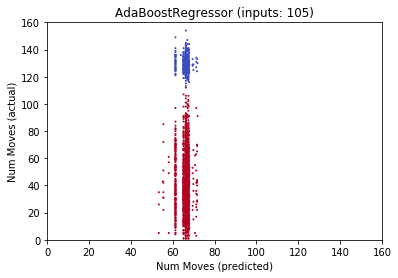

In [55]:
regress_and_chart(X_train_recode_divergent, y_train_regress, X_test_recode_divergent, y_test_regress)

<b><span style="color:indian red; font-size:14pt">No signal.</span></b>

## 6. Model: Value offsets between deck positions

#### 6.1 Visualize card values between pairs of positions.
I may expect to see dark diagonal lines if certain values often appear a certain offset away in winning decks. I do <b>NOT</b> see this however, as this first set of charts appear pretty random.

In [56]:
numrows=9
ax_row = 0
ax_col = -1
tickrange=range(1,14)
xticklabels=['A','','','','','','7','','','','','','K']
yticklabels=['Ace','2','3','4','5','6','7','8','9','10','Jack','Queen','King']

fig, axes = plt.subplots(nrows=numrows, ncols=6, figsize=[24,4*numrows], sharey=True)
_=fig.suptitle(t='Ace-to-King values per pair of deck positions (darker=more won)', fontsize=25, y=.905)

x = 'val_0'
for column in value_column_names:
    if int(column[4:]) == 0:
        continue
    y = column
    
    if ax_col == 5:
        ax_row+=1
        ax_col=0
    else: 
        ax_col+=1        
    ax = axes[ax_row][ax_col]
    
    _=ax.scatter(x=data[x], y=data[y], c=data['won'], cmap='binary', s=80, alpha=.6)
    _=ax.set_xticks(tickrange)
    _=ax.set_xticklabels(xticklabels)
    _=ax.set_yticks(tickrange)
    _=ax.set_yticklabels(yticklabels)

    _=ax.set_title(label='{} - {}'.format(x[4:], y[4:]), fontdict={'fontsize':20})


Not expanding this beyond initial x0 card, as spot checking others also does not suggest obvious patterns.

#### 6.2 Create value offset features
For each of the first 51 cards, build a new column storing its value difference from each subsequent card. ~~Normalize between [-1, 1] by dividing by 12.~~

In [57]:
for col in value_column_names[:51]:
    this_col_num = int(col[4:])
    for other in value_column_names[this_col_num+1:]:
        other_col_num = int(other[4:])

        new_col_name = 'val_diff_'+str(this_col_num)+'_'+str(other_col_num)
        data.loc[:,new_col_name] = pd.Categorical(data.loc[:,col].astype('int') - data.loc[:,other].astype('int'))

#### 6.3 Create filter to identify new features

In [58]:
val_diff_column_names = list(filter(lambda x: x[0:8]=='val_diff',list(data.columns)))
val_diff_columns = data.columns.isin(val_diff_column_names)

data.loc[:0,value_columns]
data.loc[:0,val_diff_columns]

val_0 val_1 val_2 val_3 val_4 val_5 val_6 val_7 val_8 val_9  ...   val_42  \
0     4     1     8     4     1     9     7    12     3    12  ...        6   

  val_43 val_44 val_45 val_46 val_47 val_48 val_49 val_50 val_51  
0      8      1      7      8      5      4      2     11     13  

[1 rows x 52 columns]

val_diff_0_1 val_diff_0_2 val_diff_0_3 val_diff_0_4 val_diff_0_5  \
0            3           -4            0            3           -5   

  val_diff_0_6 val_diff_0_7 val_diff_0_8 val_diff_0_9 val_diff_0_10  \
0           -3           -8            1           -8            -5   

       ...       val_diff_47_48 val_diff_47_49 val_diff_47_50 val_diff_47_51  \
0      ...                    1              3             -6             -8   

  val_diff_48_49 val_diff_48_50 val_diff_48_51 val_diff_49_50 val_diff_49_51  \
0              2             -7             -9             -9            -11   

  val_diff_50_51  
0             -2  

[1 rows x 1326 columns]

#### 6.4 Create input arrays
Because of memory constraints on my hardware, I am using only a fraction of the 1,326 val_diff columns to create dummy variables and model.

In [59]:
train, test = split_train_test(data)

X_train_val_diffs = array_with_dummies(train, val_diff_columns[:len(val_diff_columns)//6])
X_test_val_diffs = array_with_dummies(test, val_diff_columns[:len(val_diff_columns)//6])

X_train_val_diffs.shape, X_test_val_diffs.shape

((7500, 2040), (2500, 2040))

#### 6.5 Run models

Accuracy: 0.8128
     vs. baseline: -0.0048


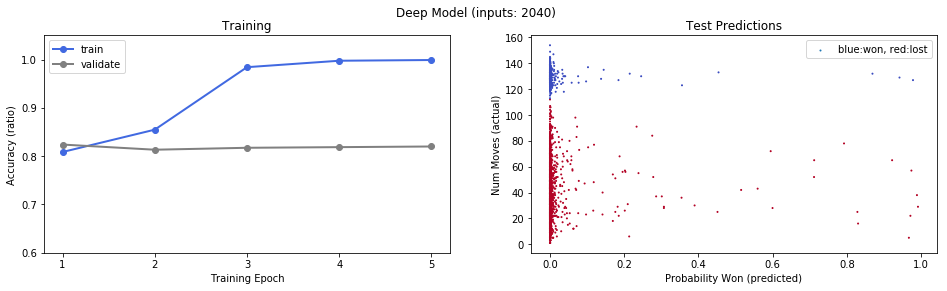

In [60]:
deep_model_and_chart(X_train_val_diffs, y_train, X_test_val_diffs, y_test)

In [61]:
regress_and_chart(X_train_val_diffs, y_train_regress, X_test_val_diffs, y_test_regress)

R^2: -0.06


<b><span style='color:indian red; font-size:14pt'>No Signal.</span></b>

## 7. Model: Deck Statistics

   * <b>How common are contiguous card values?</b> 
          Sum number of contiguous values (next card value higher or lower by ONE) throughout deck.
          ex. A perfectly contiguous deck might ensure dependent cards (contiguous ones) aren't far from each other.

   * <b>How well are values balanced between the two halves of the deck?</b> 
          Sum card values for each half.
          ex. If h1 low and h2 high, the low-value piles (mostly comprised of h1) might be tough targets for high-
          value playing deck (mostly comprised of h2).

   * <b>How is the color spread among alternating cards?</b> 
          Sum indexes for even and odd deck positions. The abs(difference) in these sums is maximized when the cards 
          perfectly alternate between red and black. Perhaps this alternation could discourage 'stuck' states where 
          all visible cards are the same color.

   * <b>How is the color balanced between the two halves of the deck?</b> 
          Sum indexes for each half. Indexes 1-26 are black cards and 27-52 are red. If h1 
          entirely black and h2 entirely red then perhaps the black piles would be easier targets for the red
          playpile. Perhaps large difference between index-sums of the piles leads to easier targets.
   * <b>How is the color balanced from top to bottom continuously?</b> 
          Collect a running sum of the index difference between each deck position to get a more precise 
          'fingerprint' of the index order of each deck. Since this method records the ordering within each deck 
          half as well, it may inform whether bunches of value differerences are helpful.  

#### 7.1 Add feature: number of contiguous values

In [62]:
num_rows = 0
first_value_column = value_column_names[0]

for row in data.index:
    num_rows += 1
    num_contiguous_values = 0
    current_value = 0
    previous_value = 0
    for column in value_column_names:
        current_value = data.loc[row, column]
        if ((column != first_value_column) & (abs(current_value - previous_value)==1)):
            num_contiguous_values += 1
        previous_value = current_value
    data.loc[row, 'z_num_contiguous_values'] = num_contiguous_values
num_rows

10000

In [63]:
contiguous_mean = data.loc[:, 'z_num_contiguous_values'].mean()
contiguous_std = data.loc[:, 'z_num_contiguous_values'].std()

data.loc[:, 'z_num_contiguous_values'] = data.loc[:, 'z_num_contiguous_values'].\
    transform(lambda x: (x - contiguous_mean) / contiguous_std)

In [64]:
assert abs(data.loc[:, 'z_num_contiguous_values'].mean() - 0)  < 0.0001
assert abs(data.loc[:, 'z_num_contiguous_values'].std() - 1) < 0.00001

#### 7.2 Add feature: value balance between halves of the deck

In [65]:
h1_deck_position_names = []
h2_deck_position_names = []

for col in value_column_names:
    if int(col[4:]) < 26:
        h1_deck_position_names.append(col)
    else:
        h2_deck_position_names.append(col)

In [66]:
h1_deck_positions = data.columns.isin(h1_deck_position_names)
h2_deck_positions = data.columns.isin(h2_deck_position_names)

In [67]:
data.loc[:, 'z_sum_h1_values'] = data.loc[:, h1_deck_positions].sum(axis=1)
data.loc[:, 'z_sum_h2_values'] = data.loc[:, h2_deck_positions].sum(axis=1)

data['z_diff_h1_h2_values'] = (data['z_sum_h1_values'] - data['z_sum_h2_values'])

In [68]:
diff_h1_h2_mean = data['z_diff_h1_h2_values'].mean()
diff_h1_h2_std = data['z_diff_h1_h2_values'].std()

data.loc[:, 'z_diff_h1_h2_values'] = data.loc[:, 'z_diff_h1_h2_values'].\
    transform(lambda x: (x - diff_h1_h2_mean) / diff_h1_h2_std)

In [69]:
assert abs(data.loc[:, 'z_diff_h1_h2_values'].mean() - 0) < 0.0001
assert abs(data.loc[:, 'z_diff_h1_h2_values'].std() - 1) < 0.0001

#### 7.3 Add feature: color balance between alternating cards

In [70]:
even_deck_position_names = []
odd_deck_position_names = []

for col in list(data.columns):
    if col[0:1] == 'x':
        if int(col[1:]) % 2 == 0:
            odd_deck_position_names.append(col)
        else:
            even_deck_position_names.append(col)

In [71]:
even_deck_positions = data.columns.isin(even_deck_position_names)
odd_deck_positions = data.columns.isin(odd_deck_position_names)

In [72]:
data.loc[:, 'z_sum_evens_indexes'] = data.loc[:, even_deck_positions].sum(axis=1)
data.loc[:, 'z_sum_odds_indexes'] = data.loc[:, odd_deck_positions].sum(axis=1)

data['z_diff_even_odd_indexes'] = (data['z_sum_evens_indexes'] - data['z_sum_odds_indexes'])

In [73]:
diff_even_odd_mean = data['z_diff_even_odd_indexes'].mean()
diff_even_odd_std = data['z_diff_even_odd_indexes'].std()

data.loc[:, 'z_diff_even_odd_indexes'] = data.loc[:, 'z_diff_even_odd_indexes'].\
    transform(lambda x: (x - diff_even_odd_mean) / diff_even_odd_std)

In [74]:
assert abs(data.loc[:, 'z_diff_even_odd_indexes'].mean() - 0) < 0.0001
assert abs(data.loc[:, 'z_diff_even_odd_indexes'].std() - 1) < 0.0001

#### 7.4 Add feature: color balance between halves of the deck

In [75]:
h1_deck_position_names = []
h2_deck_position_names = []

for col in card_column_names:
    if int(col[1:]) < 26:
        h1_deck_position_names.append(col)
    else:
        h2_deck_position_names.append(col)

In [76]:
h1_deck_positions = data.columns.isin(h1_deck_position_names)
h2_deck_positions = data.columns.isin(h2_deck_position_names)

In [77]:
data.loc[:, 'z_sum_h1_indexes'] = data.loc[:, h1_deck_positions].sum(axis=1)
data.loc[:, 'z_sum_h2_indexes'] = data.loc[:, h2_deck_positions].sum(axis=1)

data['z_diff_h1_h2_indexes'] = (data['z_sum_h1_indexes'] - data['z_sum_h2_indexes'])

In [78]:
diff_h1_h2_mean = data['z_diff_h1_h2_indexes'].mean()
diff_h1_h2_std = data['z_diff_h1_h2_indexes'].std()

data.loc[:, 'z_diff_h1_h2_indexes'] = data.loc[:, 'z_diff_h1_h2_indexes'].\
    transform(lambda x: (x - diff_h1_h2_mean) / diff_h1_h2_std)

In [79]:
assert abs(data.loc[:, 'z_diff_h1_h2_indexes'].mean() - 0) < 0.0001
assert abs(data.loc[:, 'z_diff_h1_h2_indexes'].std() - 1) < 0.0001  

#### 7.5 Add feature: color balance from top to bottom continuously

In [80]:
num_rows = 0
first_card_column = card_column_names[0]

for row in data.index[:]:
    num_rows += 1
    current_value = 0
    previous_value = 0
    this_diff = 0
    running_diff = 0
    for column in card_column_names:
        current_value = data.loc[row, column]
        this_diff = previous_value - current_value
        if (column != first_card_column):
            running_diff += this_diff
        previous_value = current_value
    data.loc[row, 'z_running_diff_indexes'] = running_diff
num_rows

10000

In [81]:
running_column_mean = data.loc[:, 'z_running_diff_indexes'].mean()
running_column_std = data.loc[:, 'z_running_diff_indexes'].std()

data.loc[:, 'z_running_diff_indexes'] = data.loc[:, 'z_running_diff_indexes'].\
    transform(lambda x: (x - running_column_mean) / running_column_std)

In [82]:
assert abs(data.loc[:, 'z_running_diff_indexes'].mean() - 0)  < 0.0001
assert abs(data.loc[:, 'z_running_diff_indexes'].std() - 1) < 0.00001

#### 7.6 Create filter for new features

In [83]:
deck_profile_column_names = \
    ['z_num_contiguous_values', 'z_diff_h1_h2_values', 'z_diff_even_odd_indexes',\
     'z_diff_h1_h2_indexes', 'z_running_diff_indexes']
deck_profile_columns = data.columns.isin(deck_profile_column_names)
deck_profile_column_names

['z_num_contiguous_values',
 'z_diff_h1_h2_values',
 'z_diff_even_odd_indexes',
 'z_diff_h1_h2_indexes',
 'z_running_diff_indexes']

#### 7.7 Summarize and visualize

##### values columns

Mean Difference | p: 0.95 | F: 0.952


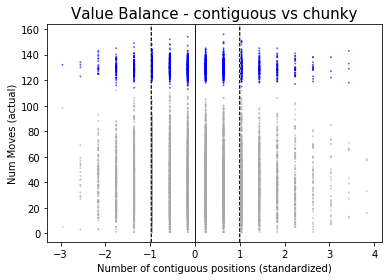

In [84]:
chart_column_stats('z_num_contiguous_values',\
                   title_str='Value Balance - contiguous vs chunky',\
                   xlabel_str='Number of contiguous positions (standardized)')

Mean Difference | p: 0.15 | F: 0.960


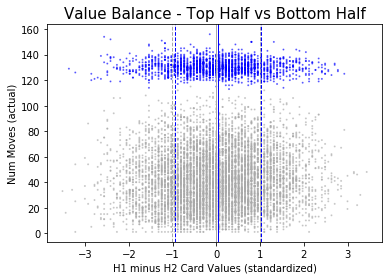

In [85]:
chart_column_stats('z_diff_h1_h2_values',\
                   title_str='Value Balance - Top Half vs Bottom Half',\
                   xlabel_str='H1 minus H2 Card Values (standardized)')

##### index columns

Mean Difference | p: 0.11 | F: 0.987


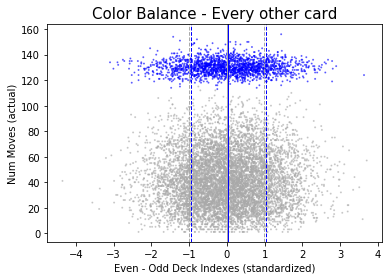

In [86]:
chart_column_stats('z_diff_even_odd_indexes',\
                   title_str='Color Balance - Every other card',\
                   xlabel_str='Even - Odd Deck Indexes (standardized)')

In [87]:
chart_column_stats('z_diff_h1_h2_indexes',\
                   title_str='Color Balance - Top Half vs Bottom Half',\
                   xlabel_str='H1 - H2 Deck Indexes (standardized)')

Mean Difference | p: 0.27 | F: 1.045


In [88]:
chart_column_stats('z_running_diff_indexes',\
                   title_str='Index Balance - column-wise subtraction method',\
                   xlabel_str='Running Column-Wise Index Diff (standardized)')

Mean Difference | p: 0.14 | F: 1.010


#### 7.8 Create input arrays

In [89]:
train, test = split_train_test(data)

In [90]:
X_train_deck_profile = np.array(train.loc[:, deck_profile_columns])
X_test_deck_profile = np.array(test.loc[:, deck_profile_columns])

Polynomial versions.

In [91]:
X_train_poly_deck_profile = poly.fit_transform(X_train_deck_profile, y_train)
X_test_poly_deck_profile = poly.fit_transform(X_test_deck_profile, y_test)
X_train_poly_deck_profile.shape
X_test_poly_deck_profile.shape

(7500, 31)

(2500, 31)

#### 7.9 Run models

Tensorflow

In [92]:
deep_model_and_chart(X_train_deck_profile, y_train, X_test_deck_profile, y_test)

Accuracy: 0.8176
     vs. baseline: 0.0000


In [93]:
deep_model_and_chart(X_train_poly_deck_profile, y_train, X_test_poly_deck_profile, y_test)

Accuracy: 0.8176
     vs. baseline: 0.0000


AdaBoostRegressor on 'num_moves'

R^2: -0.03


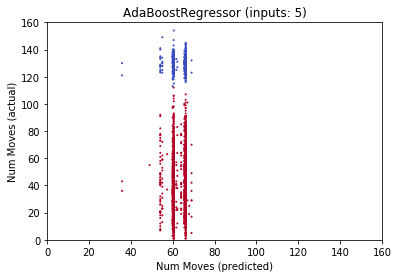

In [94]:
regress_and_chart(X_train_deck_profile, y_train_regress, X_test_deck_profile, y_test_regress)

R^2: -0.06


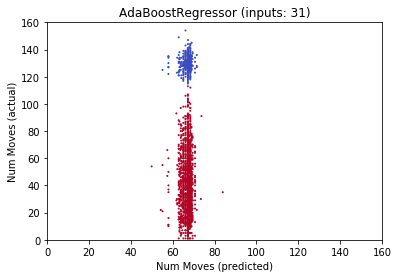

In [95]:
regress_and_chart(X_train_poly_deck_profile, y_train_regress, X_test_poly_deck_profile, y_test_regress)

<b><span style="color:indian red; font-size:14pt">No signal.</span></b>

## 8. Model: Identify Quick Losers

Is it possible to at least identify those nearly unplayable decks which lose after a short number of moves?

Perhaps a user would find value in avoiding decks which don't justify the time it takes to shuffle.

#### 8.1 Find minimum move threshold for a 'fun' deck

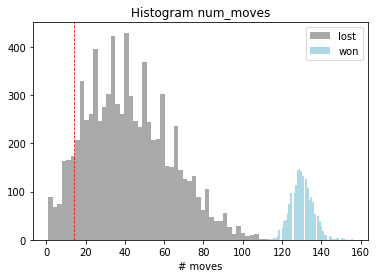

In [96]:
_=plt.hist(data.loc[data.won==0].num_moves,bins=50, label='lost', color='darkgrey')
_=plt.hist(data.loc[data.won==1].num_moves,bins=50, label='won', color='lightblue')
_=plt.axvline(x=14, color='red', linewidth=.8, linestyle='--')
_=plt.xlabel('# moves')
_=plt.legend()
_=plt.title('Histogram num_moves')

In [97]:
data.loc[data.num_moves<14, 'fun'] = 0
data.loc[data.num_moves>=14, 'fun'] = 1

#### 8.2 Create input arrays

In [98]:
train, test = split_train_test(data)

In [99]:
y_train_fun = np.array(train.loc[:,(train.columns=='fun')].iloc[:,0])
y_test_fun = np.array(test.loc[:,(test.columns=='fun')].iloc[:,0])

y_train_fun.shape, y_test_fun.shape

((7500,), (2500,))

#### 8.3 Run models

In [100]:
print('New baseline (fun == 1 in the test set): {}'.format(len(test.loc[test.fun==1])/len(test)))

New baseline (fun == 1 in the test set): 0.9356


Accuracy: 0.9348
     vs. baseline: -0.0008


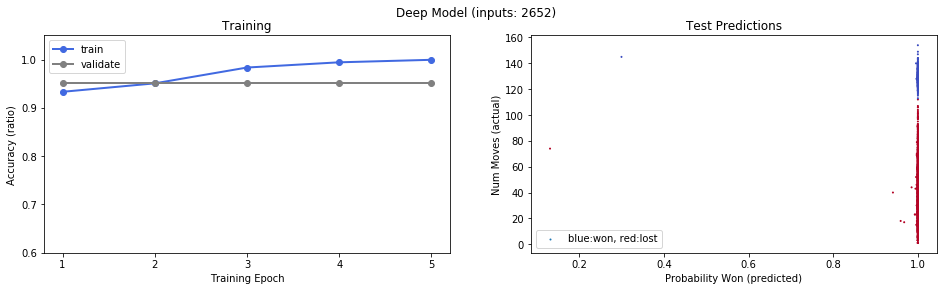

In [101]:
deep_model_and_chart(X_train, y_train_fun, X_test, y_test_fun, baseline=.9356)

Accuracy: 0.9356
     vs. baseline: -0.0000


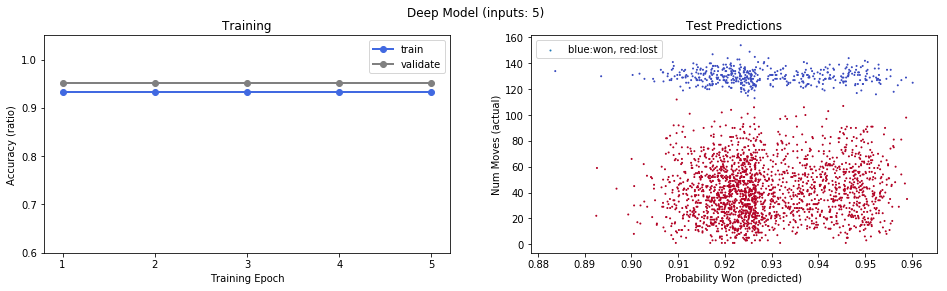

In [102]:
deep_model_and_chart(X_train_deck_profile, y_train_fun, X_test_deck_profile, y_test_fun, baseline=.9356)

Accuracy: 0.9356
     vs. baseline: -0.0000


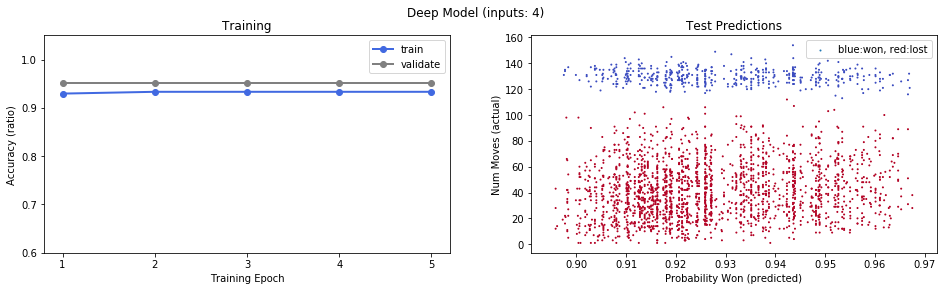

In [103]:
deep_model_and_chart(X_train_important_column_features,y_train_fun,X_test_important_column_features,\
                     y_test_fun,baseline=.9356)

<b><span style="color:indian red; font-size:14pt">No signal.</span></b>
No 'fun' generalization found for these sets of training data. Model always predicts 'fun'.

## 9. Model: Gut Check

Add a noisy explanatory column to see if models can properly classify won/lost when at least one column has predictive ability.

#### 9.1 Degrade num_moves feature with random noise

In [104]:
add_noisy_explanatory = True

if add_noisy_explanatory:
    import random
    random.seed(0)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # ensure num_moves is not already modified by re-importing raw values saved earlier
        train.loc[:,'num_moves'] = y_train_regress
        test.loc[:,'num_moves'] = y_test_regress
        
        # randomly modify 'num_moves' in the training & testing sets.
        train_sample_row_indexes = train.num_moves.sample(len(train.num_moves)//1).index
        test_sample_row_indexes = test.num_moves.sample(len(test.num_moves)//1).index
        
        train.loc[train_sample_row_indexes, 'num_moves'] = train.loc[train_sample_row_indexes, 'num_moves'].\
            transform(lambda x: x*(random.choice(np.linspace(.85,1.15,num=5))))
        test.loc[test_sample_row_indexes, 'num_moves'] = test.loc[test_sample_row_indexes, 'num_moves'].\
            transform(lambda x: x*(random.choice(np.linspace(.85,1.15,num=5))))

#### 9.2 Create input arrays

In [105]:
X_train_with_dummies_gut_check = \
    np.array(train.loc[:, (train.columns.isin(card_column_names))|(train.columns == 'num_moves')])
X_test_with_dummies_gut_check = \
    np.array(test.loc[:, (test.columns.isin(card_column_names))|(test.columns == 'num_moves')])

X_train_with_dummies_gut_check.shape
X_test_with_dummies_gut_check.shape

(7500, 53)

(2500, 53)

#### 9.3 Run models

Tensorflow

Accuracy: 0.9888
     vs. baseline: 0.1712


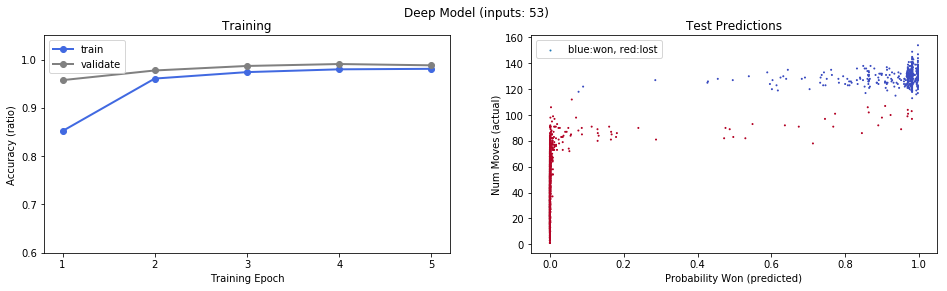

In [106]:
deep_model_and_chart(X_train_with_dummies_gut_check, y_train, X_test_with_dummies_gut_check, y_test)

AdaBoostRegressor on 'num_moves'

R^2: 0.98


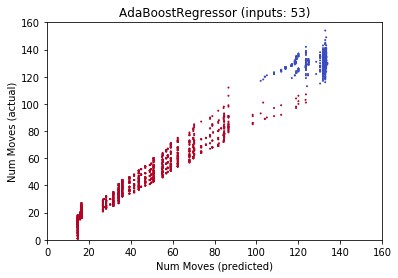

In [107]:
regress_and_chart(X_train_with_dummies_gut_check, y_train_regress, X_test_with_dummies_gut_check, y_test_regress)

<b><span style="color:lightseagreen; font-size:14pt">Signal found.</span></b>

The deep model has no problem predicting won/lost when a degraded num_moves field is added to the original 52 card index columns.

## 10. Conclusions and Questions

### Conclusions:

I believe winning decks are unique and win through sufficiently complex processes (minimum of 115 moves) that their initial states are indistiguishable.
* Although a trained TensorFlow classifier could fully memorize the 7500 training decks and correctly classify 100% of samples pulled from within, it could not generalize to new decks with any of my feature sets.
* The t-tests of the winning and losing means across all 'deck quality' features suggest no difference between winning and losing decks.
* I also tried to identify just "unplayable" decks (those which lose after a small number of moves), with the theory that they may be a more specialized subset, but also found no signal.
* My personal experience agrees, in that I often find a WIN comes down to a single 'linchpin' card that either breaks a logjam or fails to appear when I need it. This deck would look statistically indistiguishable from a deck where that linchpin card is offset by a single card.
* As a final gut-check of my model, I added in a noise-degraded copy of the <b>num_moves</b> feature to the training data and showed 99% accuracy in classification.

### Ways to improve?:

I would love to hear thoughts on whether successful prediction sounds possible, and how I might improve. 

Some problems I see are:
* My Solitaire playing algorithm only achieves ~18% success but research shows humans should be able to achieve [~43%][1]. If I improve the algorithm, perhaps the wider pool of winnable decks might be more generalizable? Alternatively, since I'm already winning the 'easiest' decks, I might expect this could actually hurt generalizability, since it would add more marginal decks that take more complex game play to win.
* I am new to deep models and am using a simple input layer. Perhaps this problem would lend itself to a differently shaped input layer representing card value, suit, and location for each card, and convolutional filters akin to vision problems?

[1]: http://www.jupiterscientific.org/sciinfo/KlondikeSolitaireReport.html